In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import json
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)
print("Setting default device to: ", device)
from PINN import CausalTrainingGradientBalancingODePINN, OdePINN, MLP_UModel, ThetaModel, InverseMosquitoPINN
from PINNModels import MLP, LambdaLayer, ConstantVariable, LearnableVariable

Setting default device to:  cuda
Setting default device to:  cuda
Setting default device to:  cuda


# Simulation Setup

In [2]:
def get_params_culex(T=10,):
    alpha = 38
    params = {
        "gamma_Aem": 1.143,
        "gamma_Ab": 0.885,
        "gamma_Ao": 2.0,
        "f_E": np.maximum(0, 0.16 * (np.exp(0.105 * (T-10)) - np.exp(0.105*(alpha-10) - (alpha-T)/(5.007)))),
        "f_P": np.maximum(0, 0.021 * (np.exp(0.162 * (T-10)) - np.exp(0.162*(alpha-10) - (alpha-T)/5.007))),
        "f_Ag": np.maximum(0, (T-9.8)/64.4),
        "mu_E": 0,
        "mu_L": 0.0304,
        "mu_P": 0.0146,
        "mu_em": 0.1,
        "mu_r": 0.08,
        "mu_A": 1/43,
        "kappa_L": 8e8,
        "kappa_P": 1e7,
        "sigma": 0.5,
        "beta_1": 141,
        "beta_2": 80,
    }
    params['m_A'] = np.maximum(-0.005941 + 0.002965 * T, params['mu_A'])
    params["f_L"] = params['f_P'] / 1.65
    params['m_E'] = params["mu_E"]
    params["m_L"] = params["mu_L"] + np.exp(-T/2)
    params["m_P"] = params["mu_P"] + np.exp(-T/2)
    return params

# Define the system of equations for numerical solution
def system(u, t, get_temperature, get_params):
    """
    inputs: a vector of  [E, L, P, Aem, Ab1, Ag1, Ao1, Ab2, Ag2, Ao2]
                          0  1  2  3    4    5    6    7    8    9
    """
    E, L, P, Aem, Ab1, Ag1, Ao1, Ab2, Ag2, Ao2 = u
    # get_temperature, get_params = args

    T = get_temperature(t)
    params = get_params(T)

    rescale_params = {'E': 1, 'L': 1, 'P': 1, 'Aem': 1, 'Ab1': 1, 'Ag1': 1, 'Ao1': 1, 'Ab2': 1, 'Ag2': 1, 'Ao2': 1}

    dE_dt = 1 / rescale_params['E'] * params['gamma_Ao'] * (params['beta_1'] * rescale_params['Ao1'] * Ao1 + params['beta_2'] * rescale_params['Ao2'] * Ao2) - (params['mu_E'] + params['f_E']) * E
    dL_dt = 1 / rescale_params['L'] * rescale_params['E'] * params['f_E'] * E - (params['m_L'] * (1 + L * rescale_params['L'] / params['kappa_L']) + params['f_L']) * L
    dP_dt = 1 / rescale_params['P'] * rescale_params['L'] * params['f_L'] * L - (params['m_P'] + params['f_P']) * P
    dAem_dt = 1 / rescale_params['Aem'] * params['f_P'] * rescale_params['P'] * P * params['sigma'] * np.exp(- params['mu_em'] * (1 + P * rescale_params['P'] / params['kappa_P'])) - (params['m_A'] + params['gamma_Aem']) * Aem
    dAb1_dt = 1 / rescale_params['Ab1'] * rescale_params['Aem'] * params['gamma_Aem'] * Aem - (params['m_A'] + params['mu_r'] + params['gamma_Ab']) * Ab1
    dAg1_dt = 1 / rescale_params['Ag1'] * rescale_params['Ab1'] * params['gamma_Ab'] * Ab1 - (params['m_A'] + params['f_Ag']) * Ag1
    dAo1_dt = 1 / rescale_params['Ao1'] * rescale_params['Ag1'] * params['f_Ag'] * Ag1 - (params['m_A'] + params['mu_r'] + params['gamma_Ao']) * Ao1
    dAb2_dt = 1 / rescale_params['Ab2'] * params['gamma_Ao'] * (rescale_params['Ao1'] * Ao1 + rescale_params['Ao2'] * Ao2) - (params['m_A'] + params['mu_r'] + params['gamma_Ab']) * Ab2
    dAg2_dt = 1 / rescale_params['Ag2'] * rescale_params['Ab2'] * params['gamma_Ab'] * Ab2 - (params['m_A'] + params['f_Ag']) * Ag2
    dAo2_dt = 1 / rescale_params['Ao2'] * rescale_params['Ag2'] * params['f_Ag'] * Ag2 - (params['m_A'] + params['mu_r'] + params['gamma_Ao']) * Ao2

    return [dE_dt, dL_dt, dP_dt, dAem_dt, dAb1_dt, dAg1_dt, dAo1_dt, dAb2_dt, dAg2_dt, dAo2_dt]


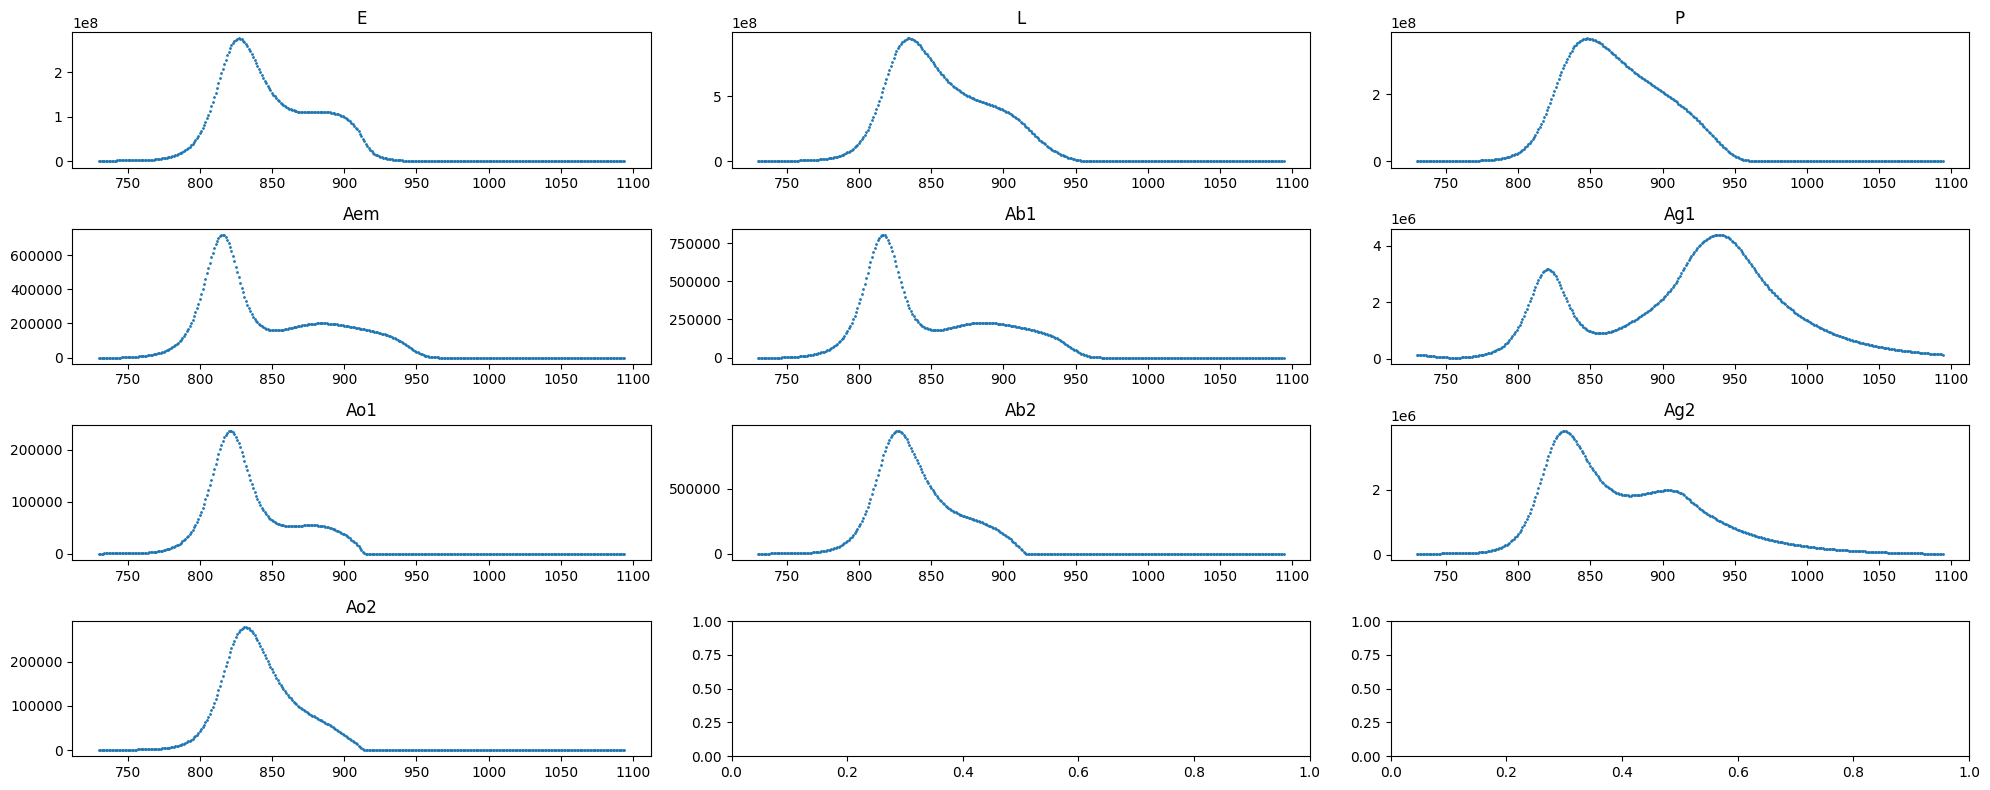

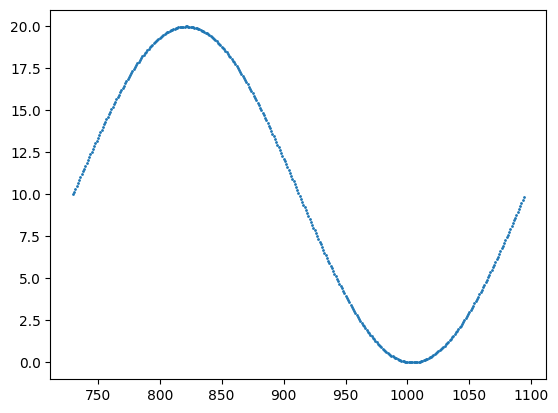

In [3]:
# Time range for the solution

def get_temperature(t):
    return 10 * np.sin(2 * np.pi / 365 * t) + 10
t_range = np.linspace(0, 365*3, 365*3*1000+1)

simulate_results = odeint(func=system, y0=np.ones((10,)) * 300, t=t_range, args=(get_temperature, get_params_culex,))


idx = np.isin(t_range, np.arange(365*2, 365*3))
t_data = torch.tensor(t_range[idx],).view(-1, 1)
u_data = torch.tensor(simulate_results[idx] )
a_data = get_temperature(t_data.detach().cpu().numpy())
a_data = torch.tensor(a_data)
params_data = get_params_culex(get_temperature(t_data.cpu().numpy()))
# for key in params_data:
#     params_data[key] = torch.tensor(params_data[key] * np.ones((t_data.shape[0], 1)))
# assert t_data.shape[0] == np.arange(365*2, 365*3).shape[0]

# Create subplots for each index from 0 to 9
fig, axs = plt.subplots(4, 3, figsize=(20, 8)) # Adjusting the size for better visualization

mosquito_stages = ["E", "L", "P", "Aem", "Ab1", "Ag1", "Ao1", "Ab2", "Ag2", "Ao2"]
for index in range(10):
    ax = axs[index//3, index%3]  # Adjusting the indexing for the new layout
    # ax.plot(t_range[idx[0]:idx[-1]], simulate_results[:, index][idx[0]:idx[-1]], ) 
    ax.scatter(t_data.detach().cpu().numpy(), u_data[:, index].detach().cpu().numpy(), s=1)
    ax.set_title(mosquito_stages[index])

plt.tight_layout()
plt.show()

plt.figure()
# plot scatter a_data
plt.scatter(t_data.detach().cpu().numpy(), a_data.detach().cpu().numpy(), s=1)

In [4]:
def plot_u_pred(mosquito_pinn, t_data, u_data, data_plot):
    if type(mosquito_pinn) == tuple:
        t_torch = mosquito_pinn[0]
        u_pred = mosquito_pinn[1]
    else:
        t_torch = torch.tensor(t_data).view(-1, 1)
        u_pred = mosquito_pinn.predict_u(t_torch)

    t_torch = t_torch.cpu().detach().numpy()
    u_pred = u_pred.cpu().detach().numpy()

    t_true = t_data.cpu().detach().numpy()
    u_true = u_data.cpu().detach().numpy()

    fig, axs = plt.subplots(4, 3, figsize=(20, 8)) # Adjusting the size for better visualization
    mosquito_stages = ["E", "L", "P", "Aem", "Ab1", "Ag1", "Ao1", "Ab2", "Ag2", "Ao2"]


    for index in range(10):
        ax = axs[index//3, index%3]  # Adjusting the indexing for the new layout
        ax.plot(t_true, u_true[:, index], c=u'#1f77b4', label=f"u_true", linewidth=3)
        ax.scatter(data_plot[0], data_plot[1][:, index], c=u'#1f77b4', label=f"u_data", s=50)
        ax.plot(t_torch, u_pred[:, index], "--", c=u'#ff7f0e', label=f"u_pred", linewidth=3)
        ax.xlim = (t_torch[0], t_torch[-1])

    for index in range(10):
        ax = axs[index//3, index%3]  # Adjusting the indexing for the new layout
        ax.legend()
        ax.set_title(mosquito_stages[index])
    plt.tight_layout()
    plt.show()


# PINN 1: original PINN framework

In [6]:
T_domain = [t_data.min().item(), t_data.max().item()]
U_domain = [u_data.min(axis=0).values, u_data.max(axis=0).values]
U_domain_mean = (U_domain[0] + U_domain[1]) / 2
U_domain[0] = torch.minimum(U_domain_mean - 1.0, U_domain[0])
U_domain[1] = torch.maximum(U_domain_mean + 1.0, U_domain[1])

Theta_domain = {}
for key in ['gamma_Aem', 'gamma_Ab', 'gamma_Ao', 'f_E', 'f_P', 'f_L', 'f_Ag', 'm_L', 'm_P', 'm_A']:
    Theta_domain[key] = [params_data[key], params_data[key]] if type(params_data[key]) is float else [params_data[key].min(), params_data[key].max()]
    Theta_domain[key] = [torch.tensor(v) for v in Theta_domain[key]]
    Theta_domain_mean = ((Theta_domain[key][0] + Theta_domain[key][1]) / 2)
    Theta_domain[key][0] = torch.minimum(Theta_domain_mean - 1.0, Theta_domain[key][0])
    Theta_domain[key][1] = torch.maximum(Theta_domain_mean + 1.0, Theta_domain[key][1])

print("T_domain", T_domain)
print("U_domain", U_domain)
print("Theta_domain", Theta_domain)
    
checkpoint_dir = "checkpoints/PINN_Mosquito_inverse"

if checkpoint_dir is not None:
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    final_checkpoint = os.path.join(checkpoint_dir, 'model_final.pt')

mosquito_pinn = InverseMosquitoPINN(T_domain=T_domain,
                            U_domain=U_domain,
                            Theta_domain=Theta_domain,
                            u_data=(t_data, u_data),
                            lambda_alpha=0.9, 
                            lambda_update=100, 
                            n_gradual_steps=0, 
                            n_warmup_steps=0, 
                            checkpoint_dir=checkpoint_dir)

if os.path.exists(final_checkpoint):
    mosquito_pinn.load_model(final_checkpoint)
else:
    logs = mosquito_pinn.train(n_steps=300000, 
                                n_epoches_per_evaluation=100,
                                n_patience=100,)

T_domain [730.0, 1094.0]
U_domain [tensor([ 2.0960e+01,  2.3704e+02,  2.0124e+00,  2.6209e-03,  3.0369e-03,
         4.3345e+04, -1.2546e-08, -1.3961e-08,  2.6876e+04, -7.9027e-09],
       device='cuda:0'), tensor([2.7543e+08, 9.4034e+08, 3.6733e+08, 7.1995e+05, 8.0531e+05, 4.3944e+06,
        2.3605e+05, 9.4323e+05, 3.8071e+06, 2.7820e+05], device='cuda:0')]
Theta_domain {'gamma_Aem': [tensor(0.1430, device='cuda:0'), tensor(2.1430, device='cuda:0')], 'gamma_Ab': [tensor(-0.1150, device='cuda:0'), tensor(1.8850, device='cuda:0')], 'gamma_Ao': [tensor(1., device='cuda:0'), tensor(3., device='cuda:0')], 'f_E': [tensor(-0.7857, device='cuda:0'), tensor(1.2143, device='cuda:0')], 'f_P': [tensor(-0.9723, device='cuda:0'), tensor(1.0277, device='cuda:0')], 'f_L': [tensor(-0.9832, device='cuda:0'), tensor(1.0168, device='cuda:0')], 'f_Ag': [tensor(-0.9208, device='cuda:0'), tensor(1.0792, device='cuda:0')], 'm_L': [tensor(-0.4696, device='cuda:0'), tensor(1.5304, device='cuda:0')], 'm_P': [t

/mnt/d/pinn-mosquito/pinn-mosquito/lib/python3.10/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


### Plotting

In [7]:
u_pred = mosquito_pinn.predict_u(t_data)
params_pred = mosquito_pinn.predict_theta(t_data)

/mnt/d/pinn-mosquito/pinn-mosquito/lib/python3.10/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


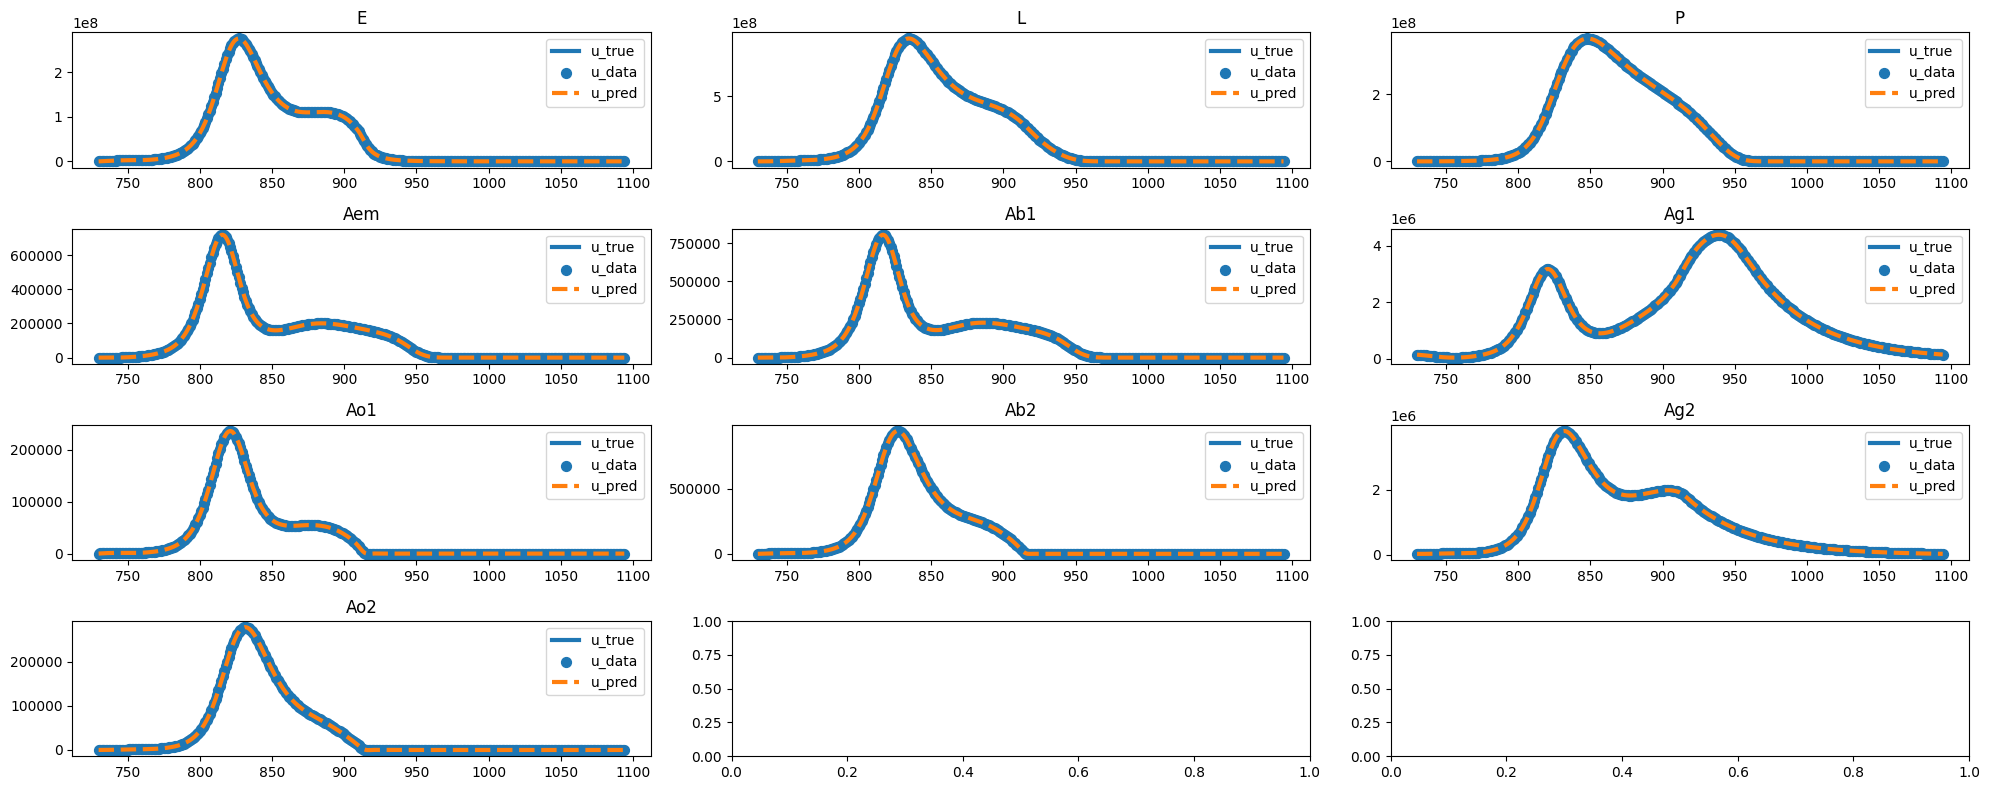

In [8]:

plot_u_pred(mosquito_pinn, t_data, u_data, (t_data.cpu().detach().numpy(), u_data.cpu().detach().numpy()))

0 10
gamma_Aem: MdAPE 0.1024, RMSE 0.001171
1 10
gamma_Ab: MdAPE 0.1077, RMSE 0.000953
2 10
gamma_Ao: MdAPE 0.0986, RMSE 0.001972
3 10
f_E: MdAPE 1.8267, RMSE 0.115945
4 10
f_P: MdAPE 0.8454, RMSE 0.003044
5 10
f_L: MdAPE 0.8443, RMSE 0.001845
6 10
f_Ag: MdAPE 60.0843, RMSE 0.000604
7 10
m_L: MdAPE 1.2740, RMSE 0.287658
8 10
m_P: MdAPE 7.3637, RMSE 0.328527
9 10
m_A: MdAPE 0.5332, RMSE 0.000592
Total RMSE: 0.136229


/tmp/ipykernel_368782/719009175.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


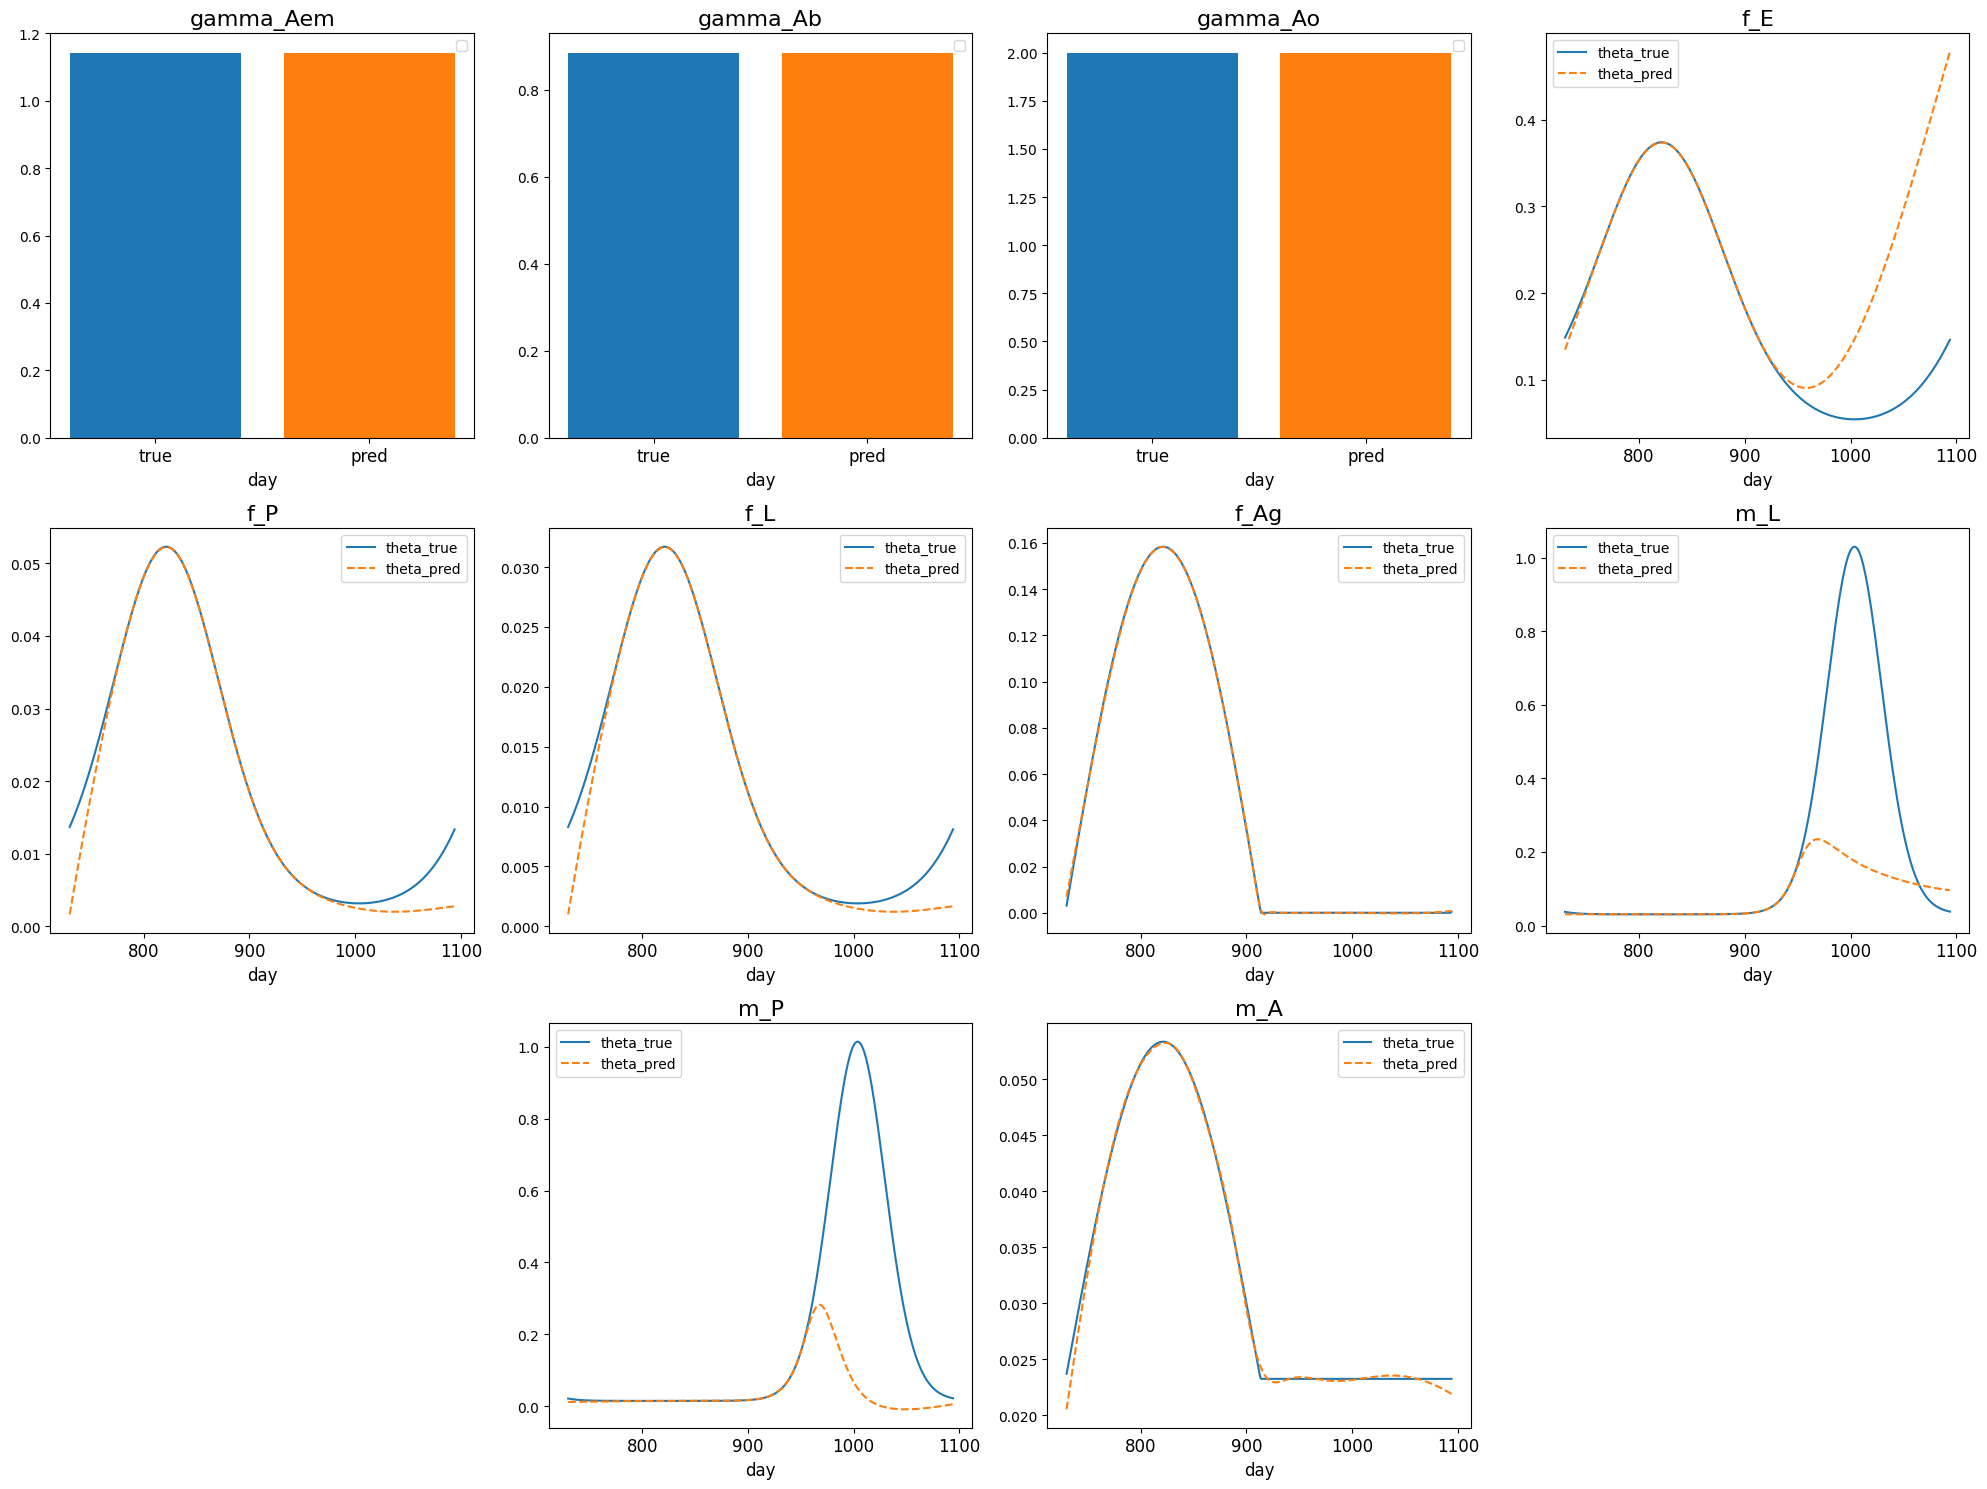

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.gridspec import GridSpec

def plot_theta_pred(mosquito_pinn, t_data, params_data):
    t_torch = torch.tensor(t_data)
    params_pred = mosquito_pinn.predict_theta(t_torch)

    t_torch = t_torch.cpu().detach().numpy()
    for key in params_pred.keys():
        params_pred[key] = params_pred[key].cpu().detach().numpy()

    # Using GridSpec to arrange subplots
    fig = plt.figure(figsize=(20, 15)) # Adjusting the figure size
    gs = GridSpec(3, 4, figure=fig)

    # Adjusting the subplot positions for centered layout
    axes = [
        fig.add_subplot(gs[0, 0]),  # First row, second column
        fig.add_subplot(gs[0, 1]),  # First row, third column
        fig.add_subplot(gs[0, 2]),  # First row, third column
        fig.add_subplot(gs[0, 3]),  # Second row, first column
        fig.add_subplot(gs[1, 0]),  # Second row, first column
        fig.add_subplot(gs[1, 1]),  # Second row, second column
        fig.add_subplot(gs[1, 2]),  # Second row, third column
        fig.add_subplot(gs[1, 3]),  # Second row, fourth column
        # fig.add_subplot(gs[2, 0]),  # Third row, first column
        fig.add_subplot(gs[2, 1]),  # Third row, second column
        fig.add_subplot(gs[2, 2]),  # Third row, third column
        # fig.add_subplot(gs[2, 3]),  # Third row, fourth column
    ]

    keys = ['gamma_Aem', 'gamma_Ab', 'gamma_Ao', 'f_E', 'f_P', 'f_L', 'f_Ag', 'm_L', 'm_P', 'm_A']
    for index, key in enumerate(keys):
        print(index, len(axes))
        ax = axes[index]
        ax.set_title(key, fontsize=16)
        if type(mosquito_pinn.theta_model.theta_model[key]) in [LearnableVariable,]:
            ax.bar(["true", "pred"], [params_data[key], params_pred[key][0,0]], color=['#1f77b4', '#ff7f0e'])
        elif type(mosquito_pinn.theta_model.theta_model[key]) in [MLP, LambdaLayer]:
            ax.plot(t_torch, params_data[key] * np.ones_like(t_torch), color='#1f77b4', label="theta_true")
            if type(mosquito_pinn.theta_model.theta_model[key]) not in [ConstantVariable,]:
                ax.plot(t_torch, params_pred[key], "--", color='#ff7f0e', label="theta_pred")
            
        if type(mosquito_pinn.theta_model.theta_model[key]) not in [ConstantVariable,]:
            rmse = np.sqrt(np.mean((params_data[key] - params_pred[key])**2))
            mdape = np.median(np.abs(params_data[key] - params_pred[key]) / (np.abs(params_data[key]) + 1e-5))
            print(f"{key}: MdAPE {mdape*100:.4f}, RMSE {rmse:.6f}")
        ax.set_xlabel("day", fontsize=12)
        ax.tick_params(axis='x', labelsize=12) 
        ax.legend()

    total_rmse = np.sqrt(np.mean([(params_data[key] - params_pred[key])**2 for key in params_pred.keys() 
                                  if type(mosquito_pinn.theta_model.theta_model[key]) not in [ConstantVariable,]]))    
    print(f"Total RMSE: {total_rmse:.6f}")
    plt.tight_layout()
    plt.show()

# Example call (use the actual `mosquito_pinn`, `t_data`, and `params_data`)
plot_theta_pred(mosquito_pinn, t_data, params_data)

# END